#  Denoising Images with an Encoder-Decoder

This notebook provides you with a complete code example that generates noisy brightfield microscopy images of particles, trains an encoder-decoder to denoise them, and visualizes the results.

## Generating the Data

Define a spherical particle ...

In [1]:
import deeptrack as dt
import numpy as np

particle = dt.Sphere(
    position=np.array([0.5, 0.5]) * 64,
    position_unit="pixel",
    radius=500 * dt.units.nm,
    refractive_index=1.45 + 0.02j,
)

... define the microscope to observe the particle ...

In [2]:
brightfield_microscope = dt.Brightfield(
    wavelength=500 * dt.units.nm,
    NA=1,
    resolution=1 * dt.units.um,
    magnification=10,
    refractive_index_medium=1.33,
    upsample=2,
    output_region=(0, 0, 64, 64),
)

... obtain the image of the microscopic particle ...

In [3]:
illuminated_sample = brightfield_microscope(particle)

... simulate the clean image of the particle ...

In [4]:
import torch

clean_particle = (
    illuminated_sample
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

... simulate the noisy image of the particle ...

In [5]:
noise = dt.Poisson(snr=lambda: 2.0 + np.random.rand())

noisy_particle = (
    illuminated_sample
    >> noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

... combine the noisy and clean particle images into a single simulation pipeline ...

In [6]:
pipeline = noisy_particle & clean_particle

... and plot a few noisy and corresponding clean particle images.

In [7]:
import matplotlib.pyplot as plt

def plot_image(title, image):
    """Plot a grayscale image with a title."""
    plt.imshow(image, cmap="gray")
    plt.title(title, fontsize=24)
    plt.axis("off")
    plt.show()

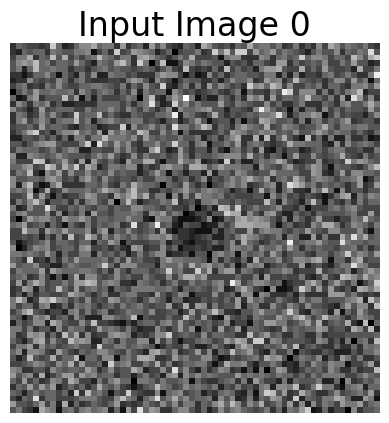

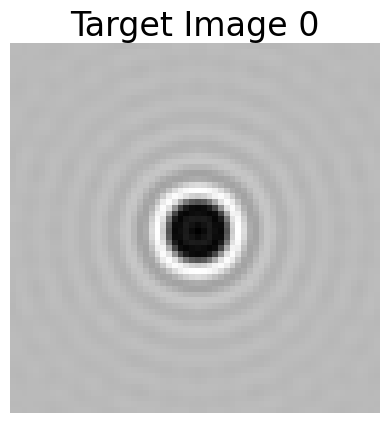

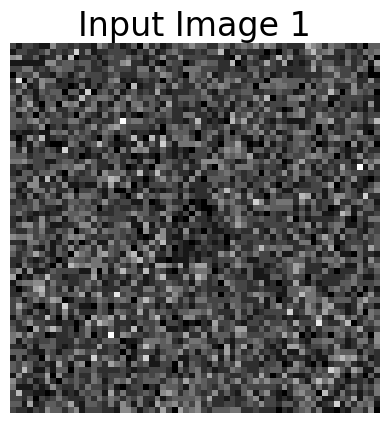

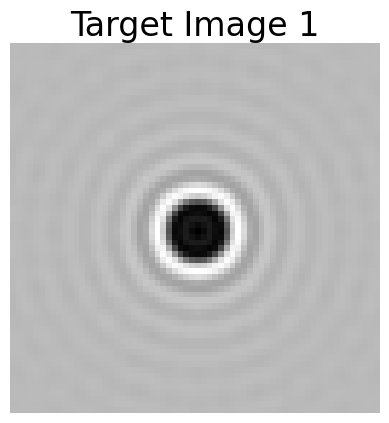

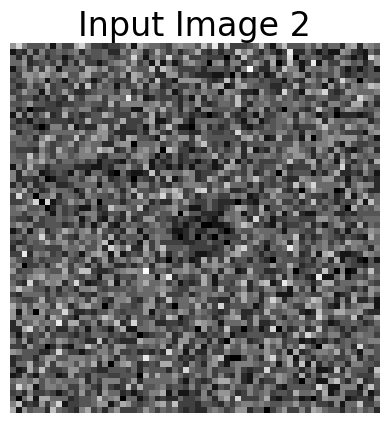

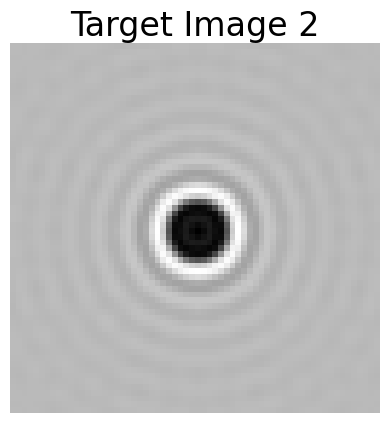

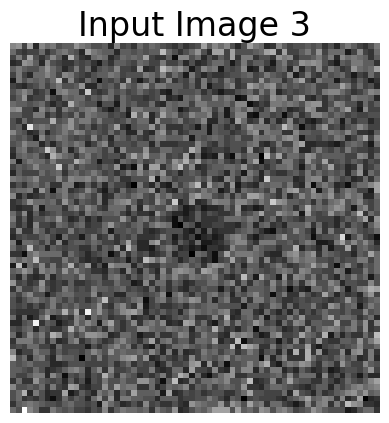

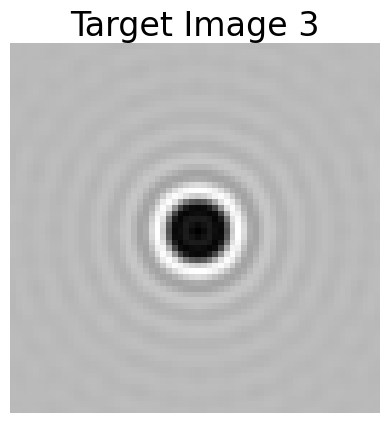

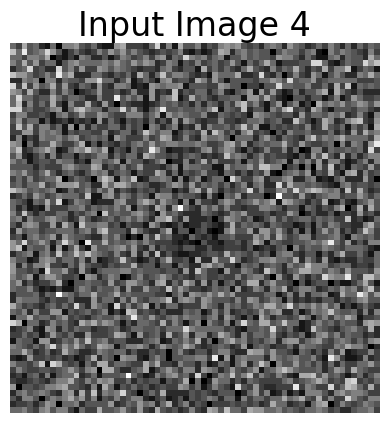

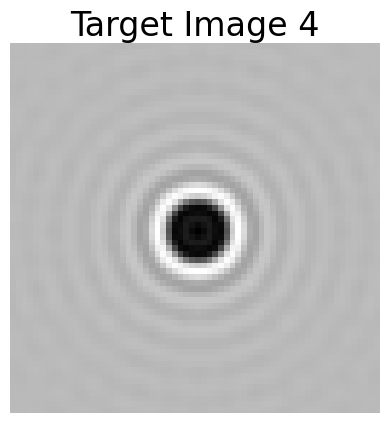

In [8]:
for i in range(5):
    input, target = pipeline.update().resolve()
    plot_image(f"Input Image {i}", input.permute(1, 2, 0))
    plot_image(f"Target Image {i}", target.permute(1, 2, 0))

## Creating a Dataset

Define a class representing a simulated dataset to generate the data for the training of the denoising encoder-decoder ...

In [9]:
from torch.utils.data import Dataset

class SimulatedDataset(Dataset):
    """Simulated dataset generating pairs of noisy and clean images."""
    
    def __init__(self, pipeline, buffer_size, replace=0):
        """Initialize the dataset."""
        self.pipeline = pipeline
        self.buffer_size = buffer_size
        self.replace = replace
        self.images = [pipeline.update().resolve() for _ in range(buffer_size)]
        
    def __len__(self):
        """Return the size of the dataset buffer."""
        return self.buffer_size

    def __getitem__(self, idx):
        """Retrieve a noisy-clean image pair from the dataset."""
        if np.random.rand() < self.replace:
            self.images[idx] = self.pipeline.update().resolve()
        image_pair = self.images[idx]
        noisy_image, clean_image = image_pair[0], image_pair[1]
        return noisy_image, clean_image

... and create the dataset and the data loader.

In [10]:
from torch.utils.data import DataLoader

dataset = SimulatedDataset(pipeline, buffer_size=256, replace=0.1)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

## Defining and Training the Encoder-Decoder

Define the encoder-decoder ...

In [11]:
import deeplay as dl

ed = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[16, 16],
    out_channels=1,
)

print(ed)

... compile it ...

In [13]:
from torch.nn import L1Loss

regressor_template = dl.Regressor(model=ed, loss=L1Loss(), optimizer=dl.Adam())
ed_regressor = regressor_template.create()

print(ed_regressor)

... and train it.

In [14]:
ed_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
ed_trainer.fit(ed_regressor, loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-03-23 20:26:41.937442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Testing the Trained Encoder-Decoder

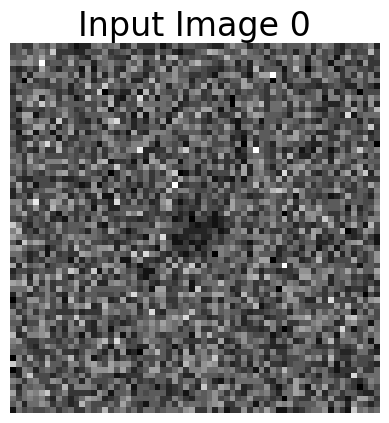

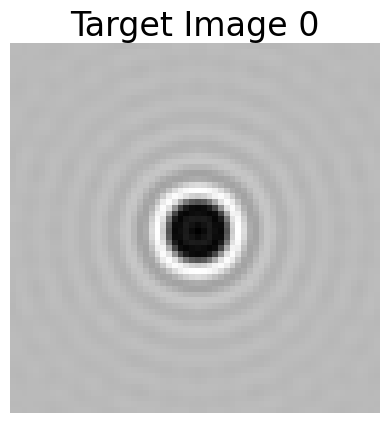

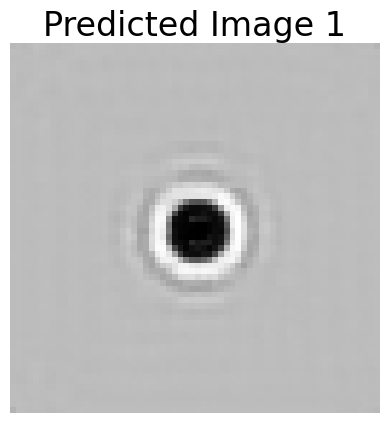

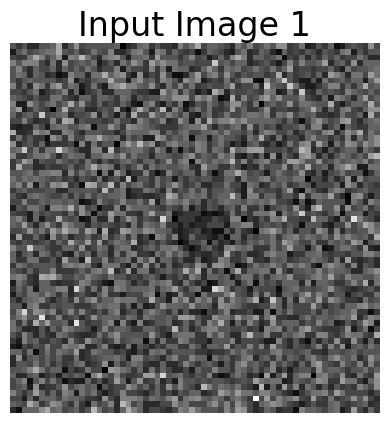

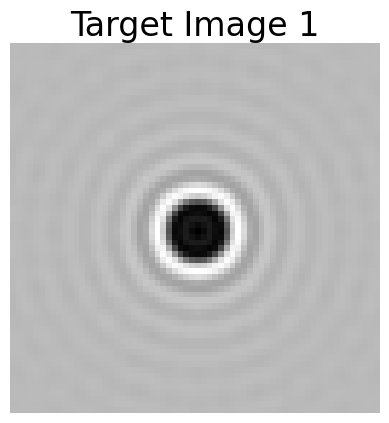

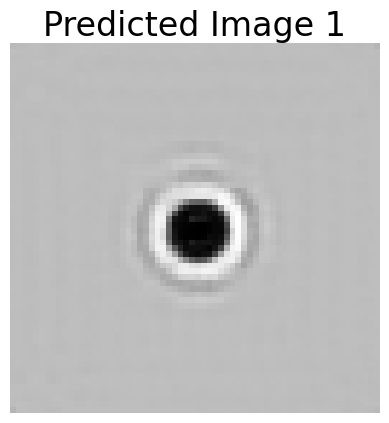

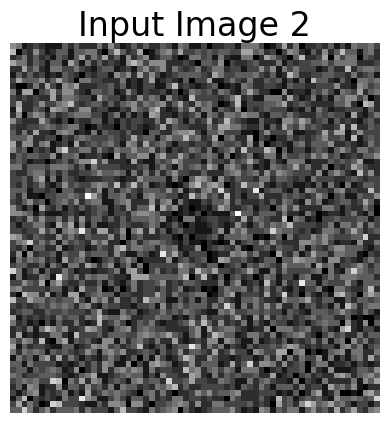

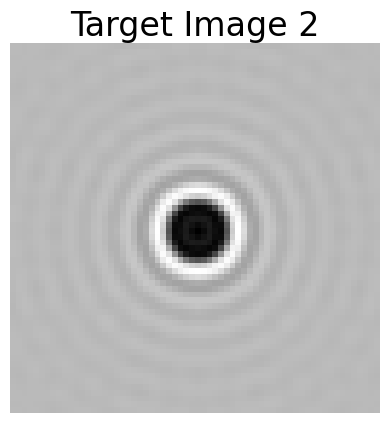

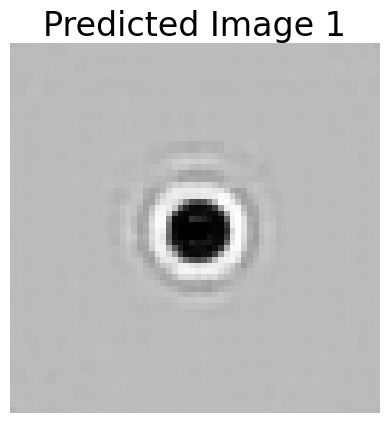

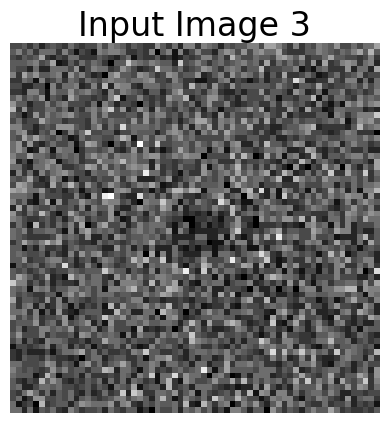

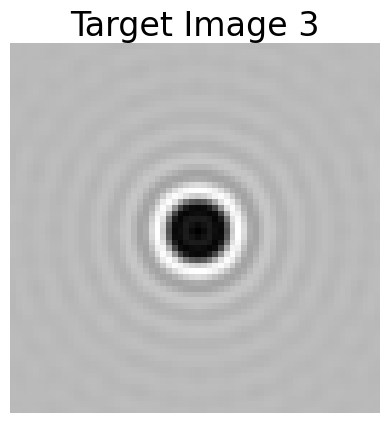

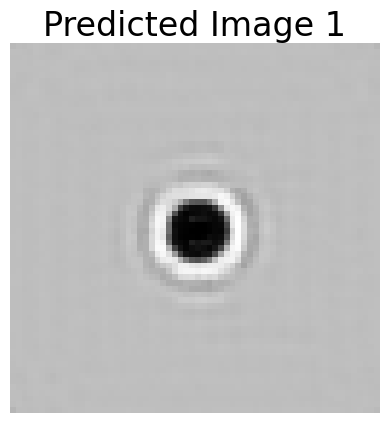

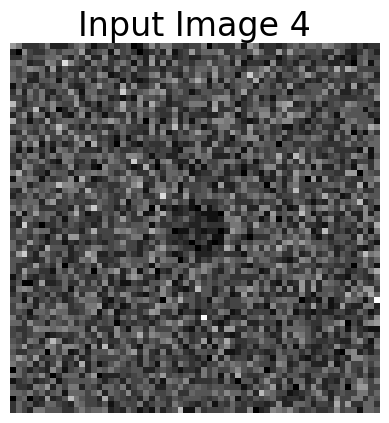

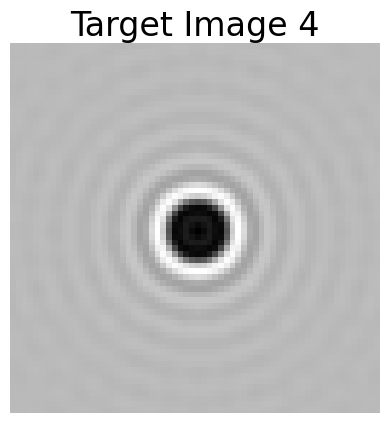

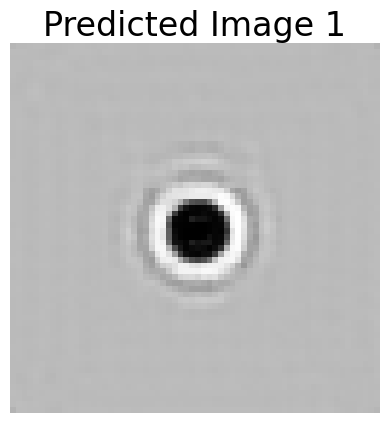

In [17]:
for i in range(5):
    input, target = pipeline.update().resolve()
    predicted = ed_regressor(input.unsqueeze(0)).detach()

    plot_image(f"Input Image {i}", input[0, :, :])
    plot_image(f"Target Image {i}", target[0, :, :])
    plot_image(f"Predicted Image {1}", predicted[0, 0, :, :])

## Checking Absence of Mode Collapse

Use the trained encoder-decoder with a blank image.

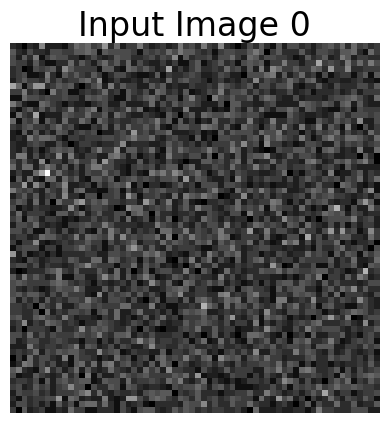

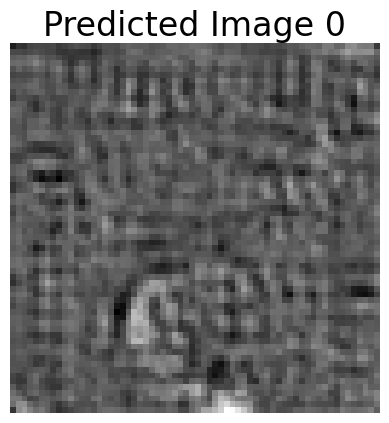

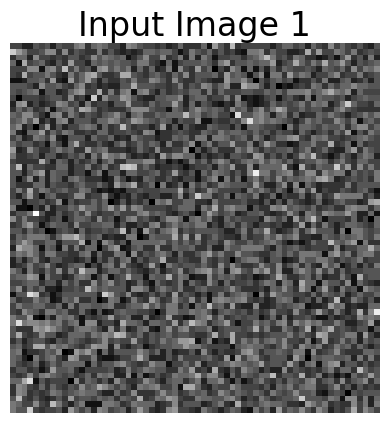

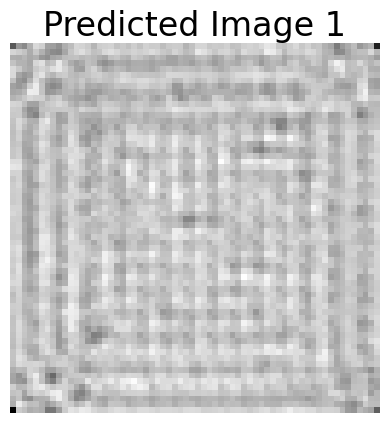

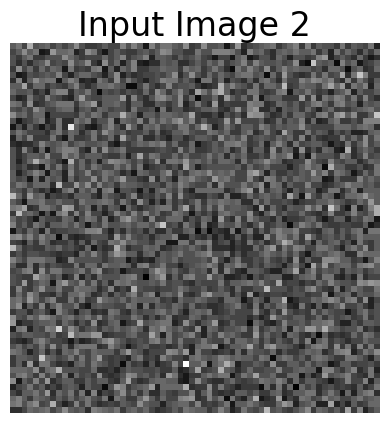

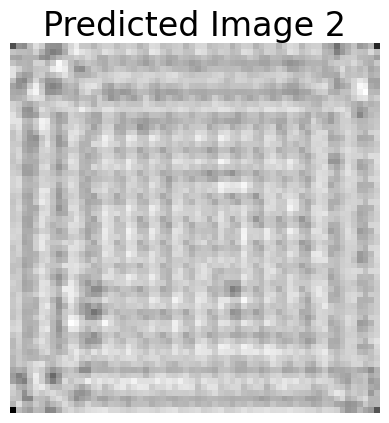

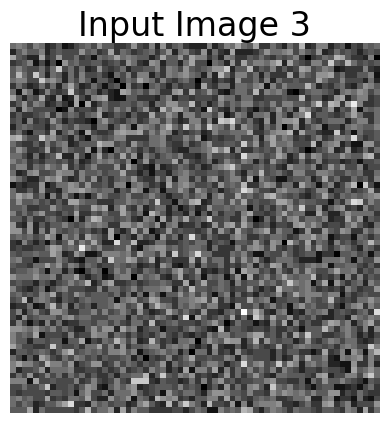

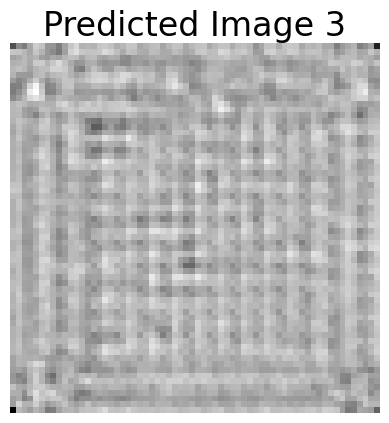

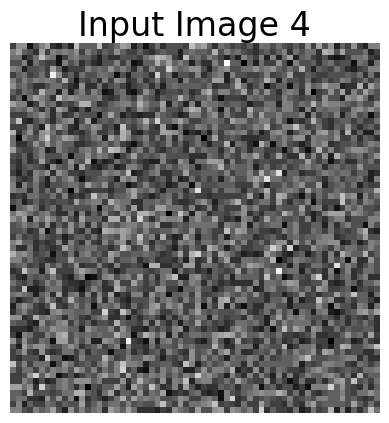

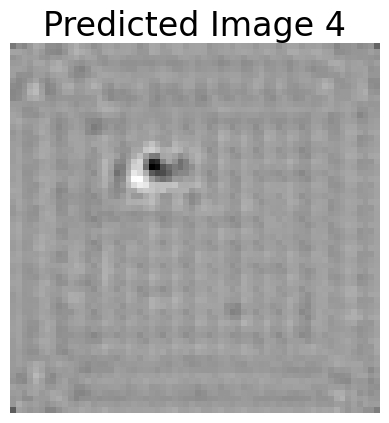

In [18]:
blank = brightfield_microscope(particle ^ 0)
blank_pipeline = (
    blank
    >> noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

for i in range(5):
    blank_image = blank_pipeline.update().resolve()
    blank_predicted = ed_regressor(blank_image.unsqueeze(0)).detach()
    plot_image(f"Input Image {i}", blank_image[0, :, :])
    plot_image(f"Predicted Image {i}", np.square(blank_predicted[0, 0, :, :]))

## Checking Generalization Capabilities

Define a pipeline with a particle with varying position and radius ...

In [19]:
diverse_particle = dt.Sphere(
    position=lambda: np.array([0.2, 0.2] + np.random.rand(2) * 0.6) * 64,
    position_unit="pixel",
    radius=lambda: 500 * dt.units.nm * (1 + np.random.rand()),
    refractive_index=1.45 + 0.02j,
)
diverse_illuminated_sample = brightfield_microscope(diverse_particle)
diverse_clean_particle = (
    diverse_illuminated_sample
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)
diverse_noisy_particle = (
    diverse_illuminated_sample
    >> noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

diverse_pipeline = diverse_noisy_particle & diverse_clean_particle

... and denoise images of diverse particles using the trained encoder-decoder.

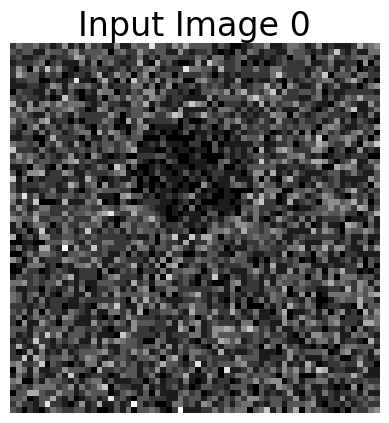

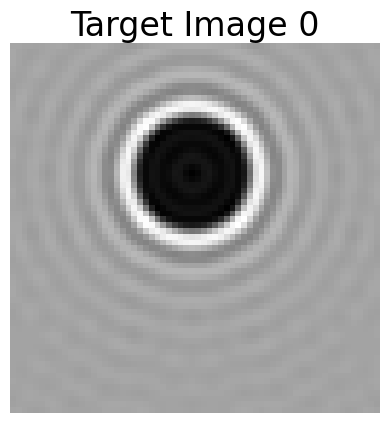

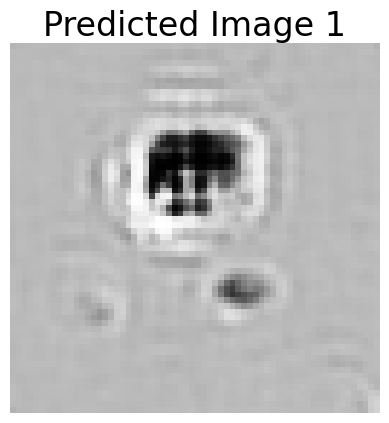

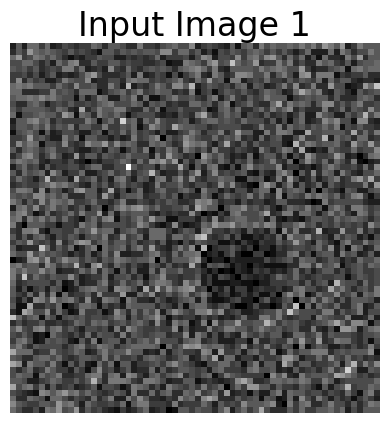

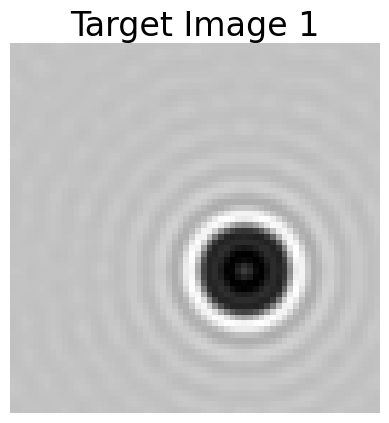

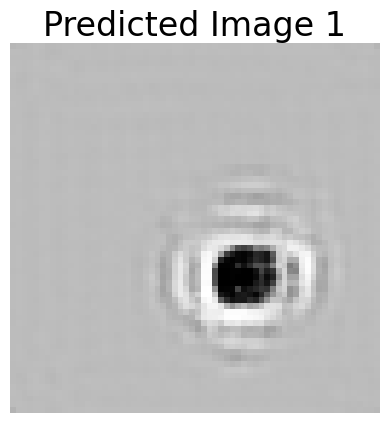

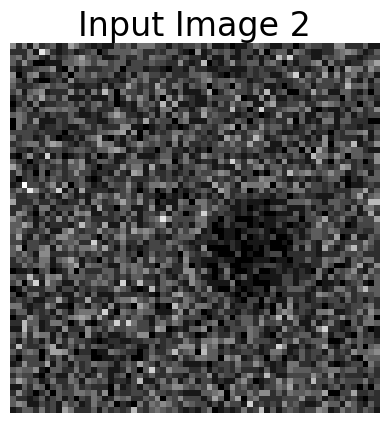

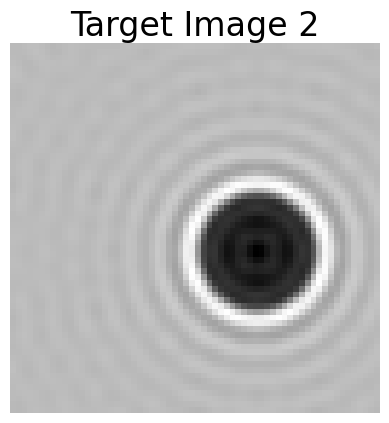

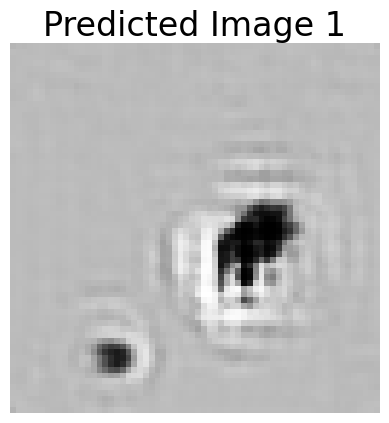

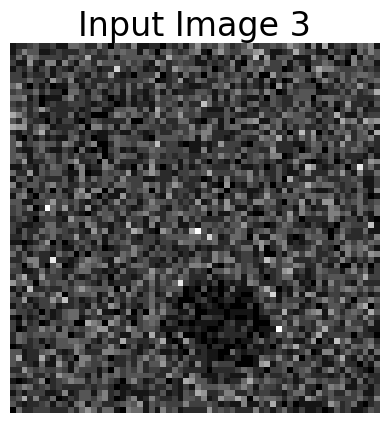

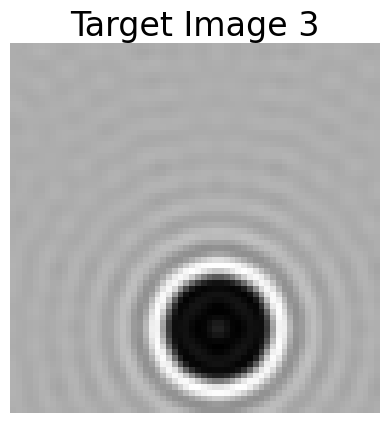

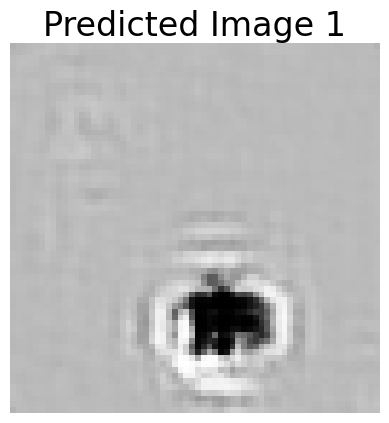

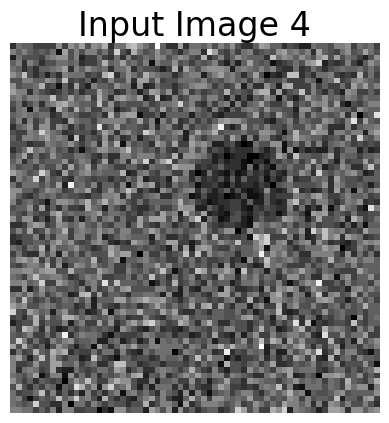

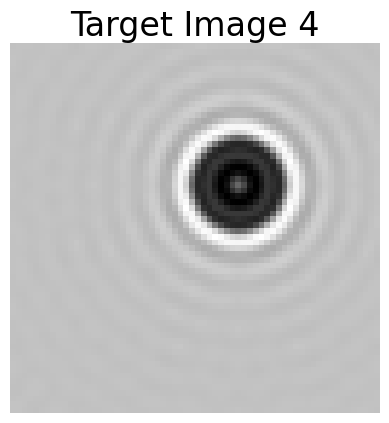

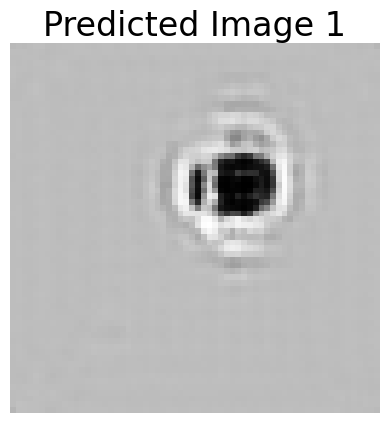

In [ ]:
for i in range(5):
    diverse_input, diverse_target = diverse_pipeline.update().resolve()
    diverse_predicted = ed_regressor(diverse_input.unsqueeze(0)).detach()

    plot_image(f"Input Image {i}", diverse_input[0, :, :])
    plot_image(f"Target Image {i}", diverse_target[0, :, :])
    plot_image(f"Predicted Image {i}", diverse_predicted[0, 0, :, :])

## Improving the Training

Train with the dataset with varying parameters ...

In [22]:
diverse_dataset = SimulatedDataset(diverse_pipeline, buffer_size=256,
                                   replace=0.1)
diverse_loader = DataLoader(diverse_dataset, batch_size=8, shuffle=True)
diverse_ed_regressor = regressor_template.create()
diverse_ed_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
diverse_ed_trainer.fit(diverse_ed_regressor, diverse_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollection              |

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


... and plot the images obtained with the improved training.

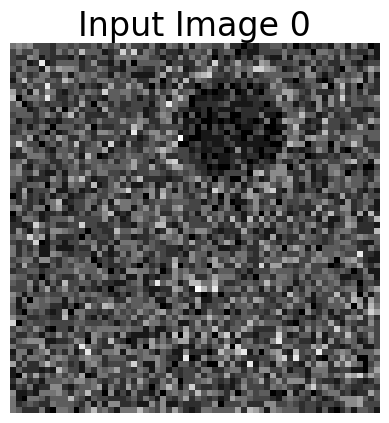

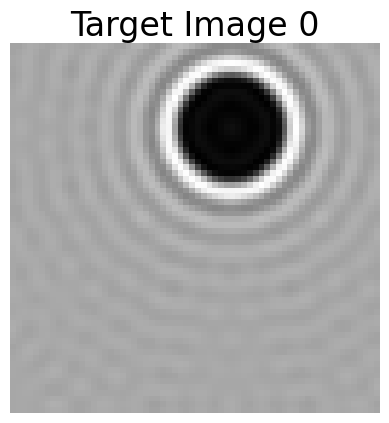

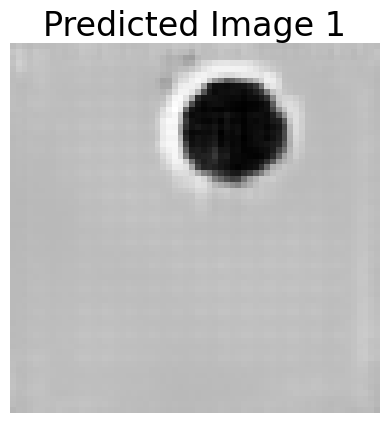

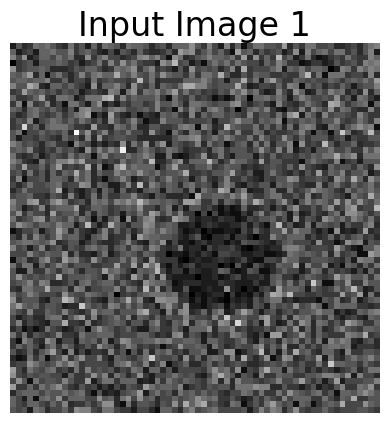

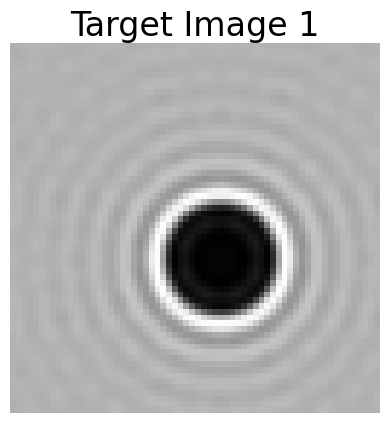

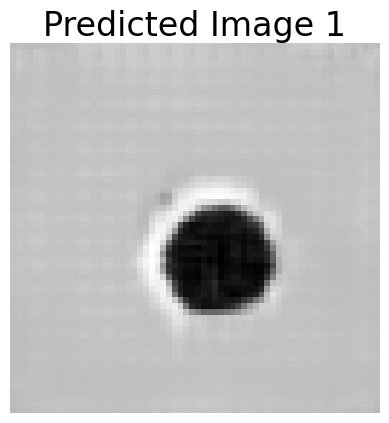

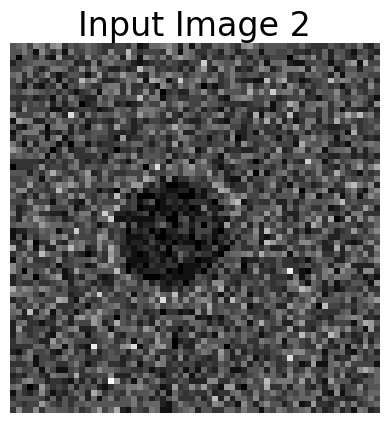

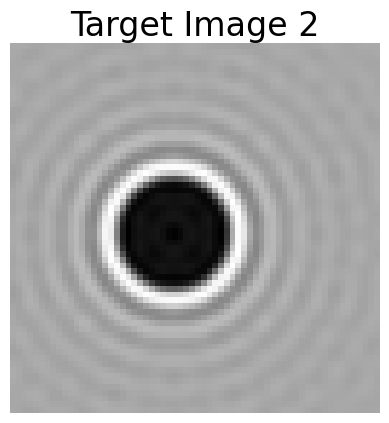

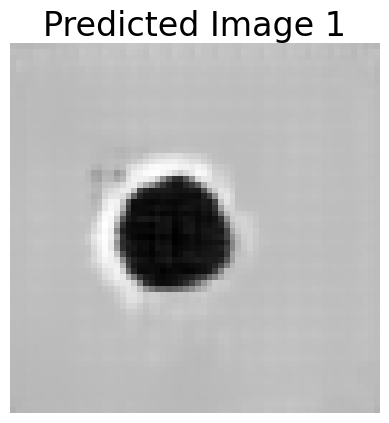

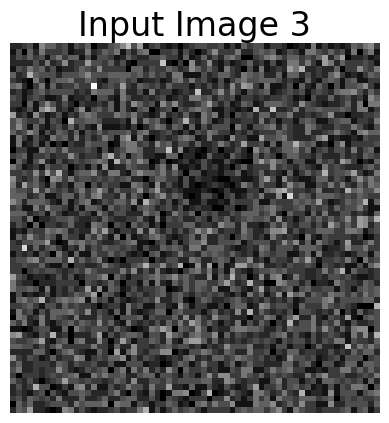

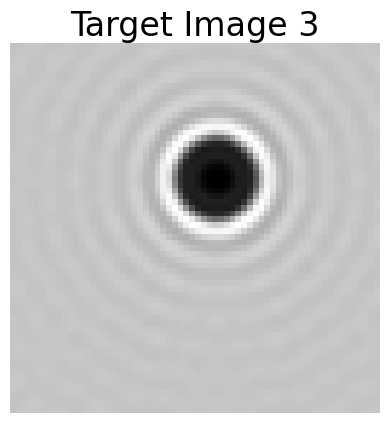

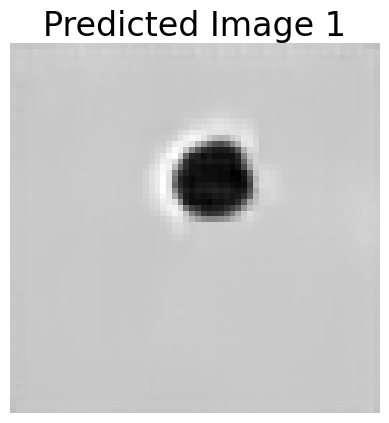

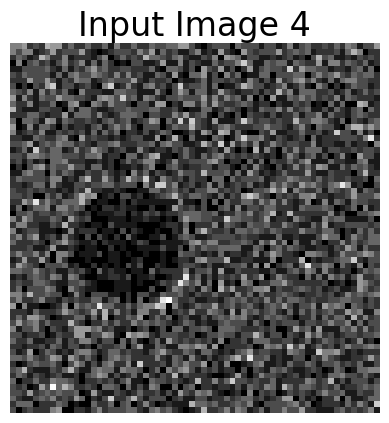

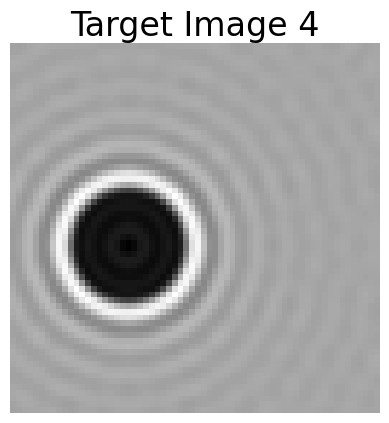

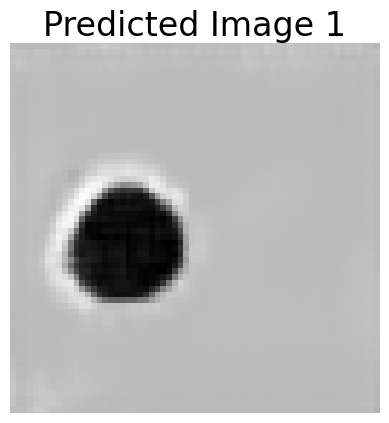

In [23]:
for i in range(5):
    diverse_input, diverse_target = diverse_pipeline.update().resolve()
    diverse_predicted = diverse_ed_regressor(diverse_input.unsqueeze(0)).detach()

    plot_image(f"Input Image {i}", diverse_input[0, :, :])
    plot_image(f"Target Image {i}", diverse_target[0, :, :])
    plot_image(f"Predicted Image {i}", diverse_predicted[0, 0, :, :])

## Improving the Encoder-Decoder

Define an improved encoder-decoder ...

In [25]:
better_ed = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[32, 64, 128],
    out_channels=1,
)

print(better_ed)

ConvolutionalEncoderDecoder2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=128)
      )
      (3): PoolLayerActivationNorma

... compile it ...

In [26]:
better_regressor_template = dl.Regressor(
    model=better_ed,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)
better_ed_regressor = better_regressor_template.create()

print(better_ed_regressor)

Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): ConvolutionalEncoderDecoder2d(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (1): PoolLayerActivationNormalization(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (2): PoolLayerActivationNormalization(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (

... train it ...

In [27]:
better_ed_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
better_ed_trainer.fit(better_ed_regressor, diverse_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollection              |

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


... and plot the images obtained with the improved encoder-decoder.

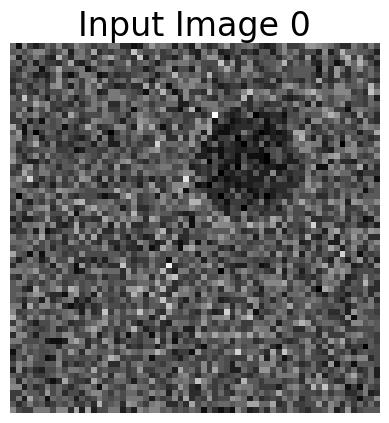

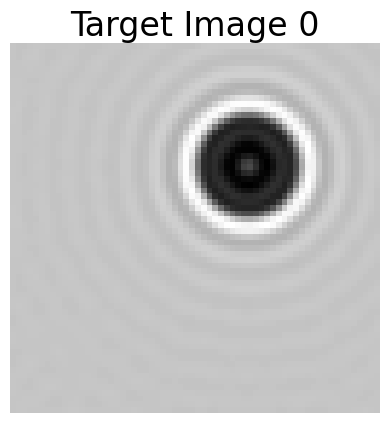

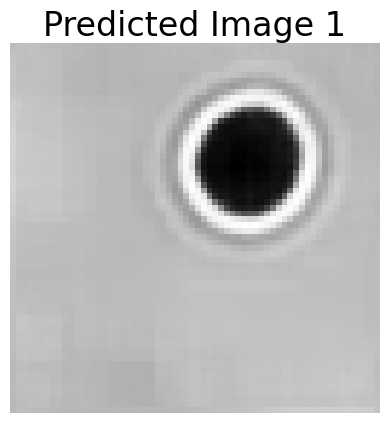

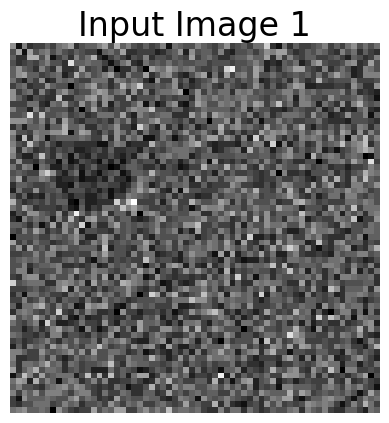

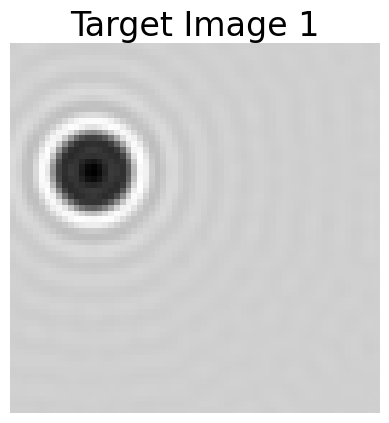

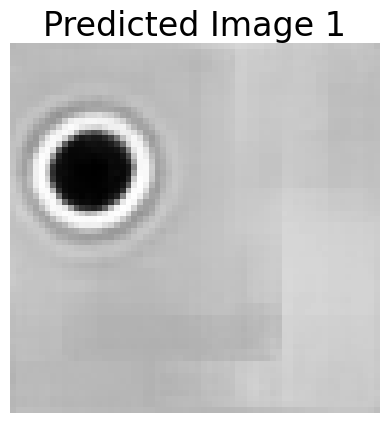

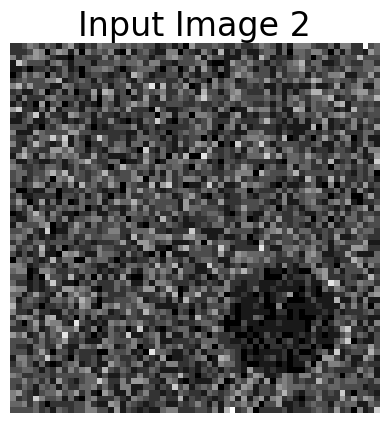

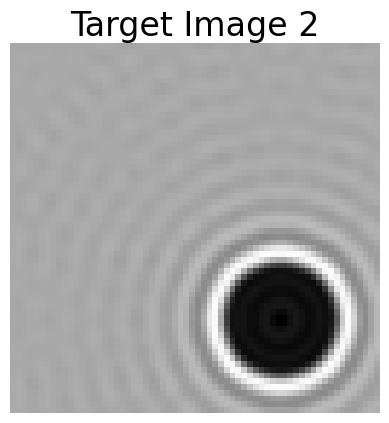

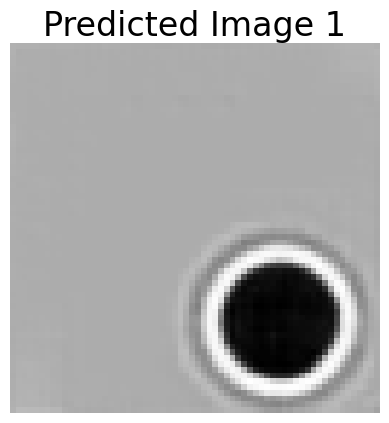

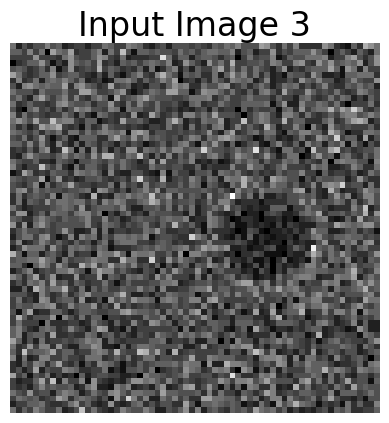

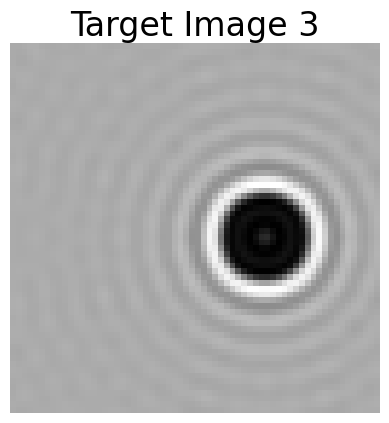

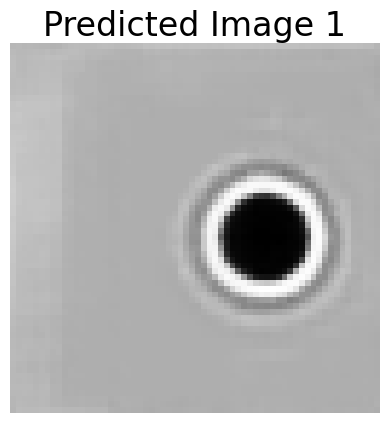

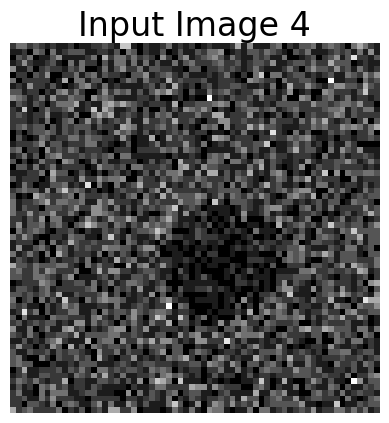

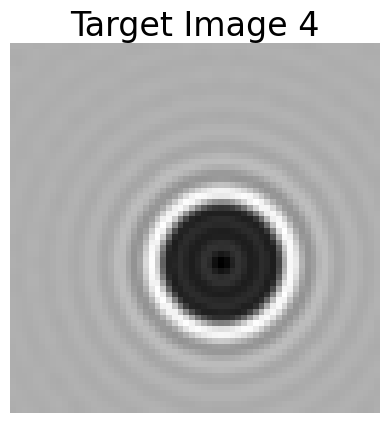

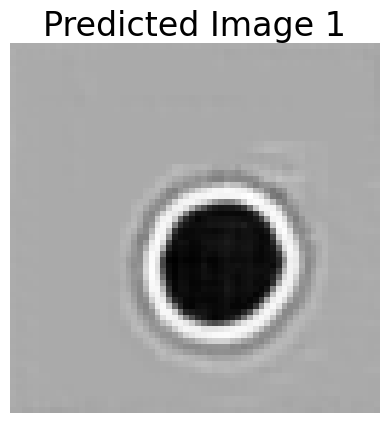

In [ ]:
for i in range(5):
    diverse_input, diverse_target = diverse_pipeline.update().resolve()
    diverse_predicted = better_ed_regressor(diverse_input.unsqueeze(0)).detach()

    plot_image(f"Input Image {i}", diverse_input[0, :, :])
    plot_image(f"Target Image {i}", diverse_target[0, :, :])
    plot_image(f"Predicted Image {i}", diverse_predicted[0, 0, :, :])